In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, roc_auc_score, roc_curve, make_scorer

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/content/healthcare_data_cleaned.csv')

In [3]:
df.drop(["ptid"], axis=1, inplace=True)

In [4]:
#encoding persistency flag
df["persistency_flag"] = df["persistency_flag"].apply(lambda x: 1 if x == "Persistent" else 0)

In [5]:
X = df.drop(["persistency_flag"], axis=1)
Y = df["persistency_flag"]

X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= 0.30, random_state=1, stratify=Y)

In [6]:
print("Shape of Training set : ", X_train.shape)
print("Shape of test set : ", X_test.shape)
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Shape of Training set :  (2396, 103)
Shape of test set :  (1028, 103)
Percentage of classes in training set:
persistency_flag
0    0.623539
1    0.376461
Name: proportion, dtype: float64
Percentage of classes in test set:
persistency_flag
0    0.623541
1    0.376459
Name: proportion, dtype: float64


In [7]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [8]:
#function to plot confusion matrix
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [9]:
#default decision tree
model0 = DecisionTreeClassifier(random_state = 1)
model0.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [10]:
dec_tree_perf_train_default = model_performance_classification_sklearn(model0, X_train, y_train)
dec_tree_perf_train_default

,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


In [11]:
dec_tree_perf_test_default = model_performance_classification_sklearn(model0, X_test, y_test)
dec_tree_perf_test_default

,Accuracy,Recall,Precision,F1
0,0.723735,0.622739,0.635884,0.629243


#Trying with balanced class weights

In [12]:
model = DecisionTreeClassifier(random_state = 1, class_weight = "balanced")
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=1)

In [13]:
dec_tree_perf_train_balanced = model_performance_classification_sklearn(model, X_train, y_train)
dec_tree_perf_train_balanced

,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


In [14]:
dec_tree_perf_test_balanced = model_performance_classification_sklearn(model, X_test, y_test)
dec_tree_perf_test_balanced

,Accuracy,Recall,Precision,F1
0,0.7607,0.653747,0.693151,0.672872


####Prepruning to reduce overfitting

In [15]:
# Choose the type of classifier.
estimator = DecisionTreeClassifier(random_state=1, class_weight="balanced")

# Grid of parameters to choose from
parameters = {
    "max_depth": np.arange(2, 7, 2),
    "max_leaf_nodes": [50, 75, 150, 250],
    "min_samples_split": [10, 30, 50, 70],
}

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(f1_score)

# Run the grid search
grid_obj = GridSearchCV(estimator, parameters, scoring=acc_scorer, cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data.
estimator.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=6, max_leaf_nodes=50,
                       min_samples_split=30, random_state=1)

In [16]:
dec_tree_perf_train_pre = model_performance_classification_sklearn(estimator, X_train, y_train)
dec_tree_perf_train_pre

,Accuracy,Recall,Precision,F1
0,0.826377,0.813747,0.747454,0.779193


In [17]:
dec_tree_perf_test_pre = model_performance_classification_sklearn(estimator, X_test, y_test)
dec_tree_perf_test_pre

,Accuracy,Recall,Precision,F1
0,0.76751,0.726098,0.678744,0.701623


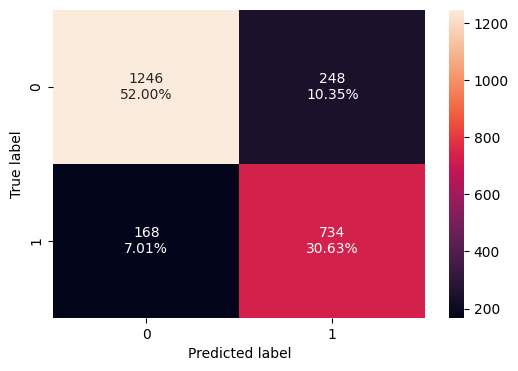

In [18]:
confusion_matrix_sklearn(estimator, X_train, y_train)

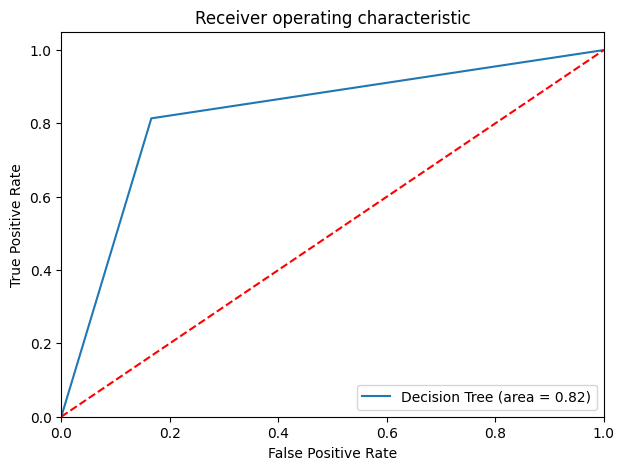

In [19]:
dt_roc_auc_train = roc_auc_score(y_train, estimator.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, estimator.predict(X_train))
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Decision Tree (area = %0.2f)" % dt_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

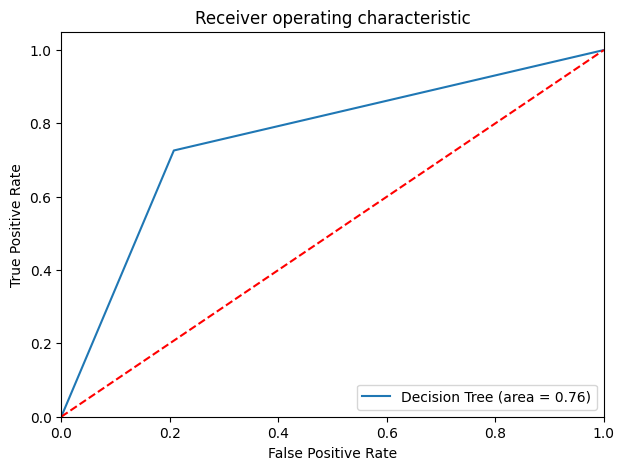

In [20]:
#testing auc
dt_roc_auc_test = roc_auc_score(y_test, estimator.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, estimator.predict(X_test))
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Decision Tree (area = %0.2f)" % dt_roc_auc_test)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

In [21]:
feature_names = list(X_train.columns)
importances = estimator.feature_importances_
indices = np.argsort(importances)

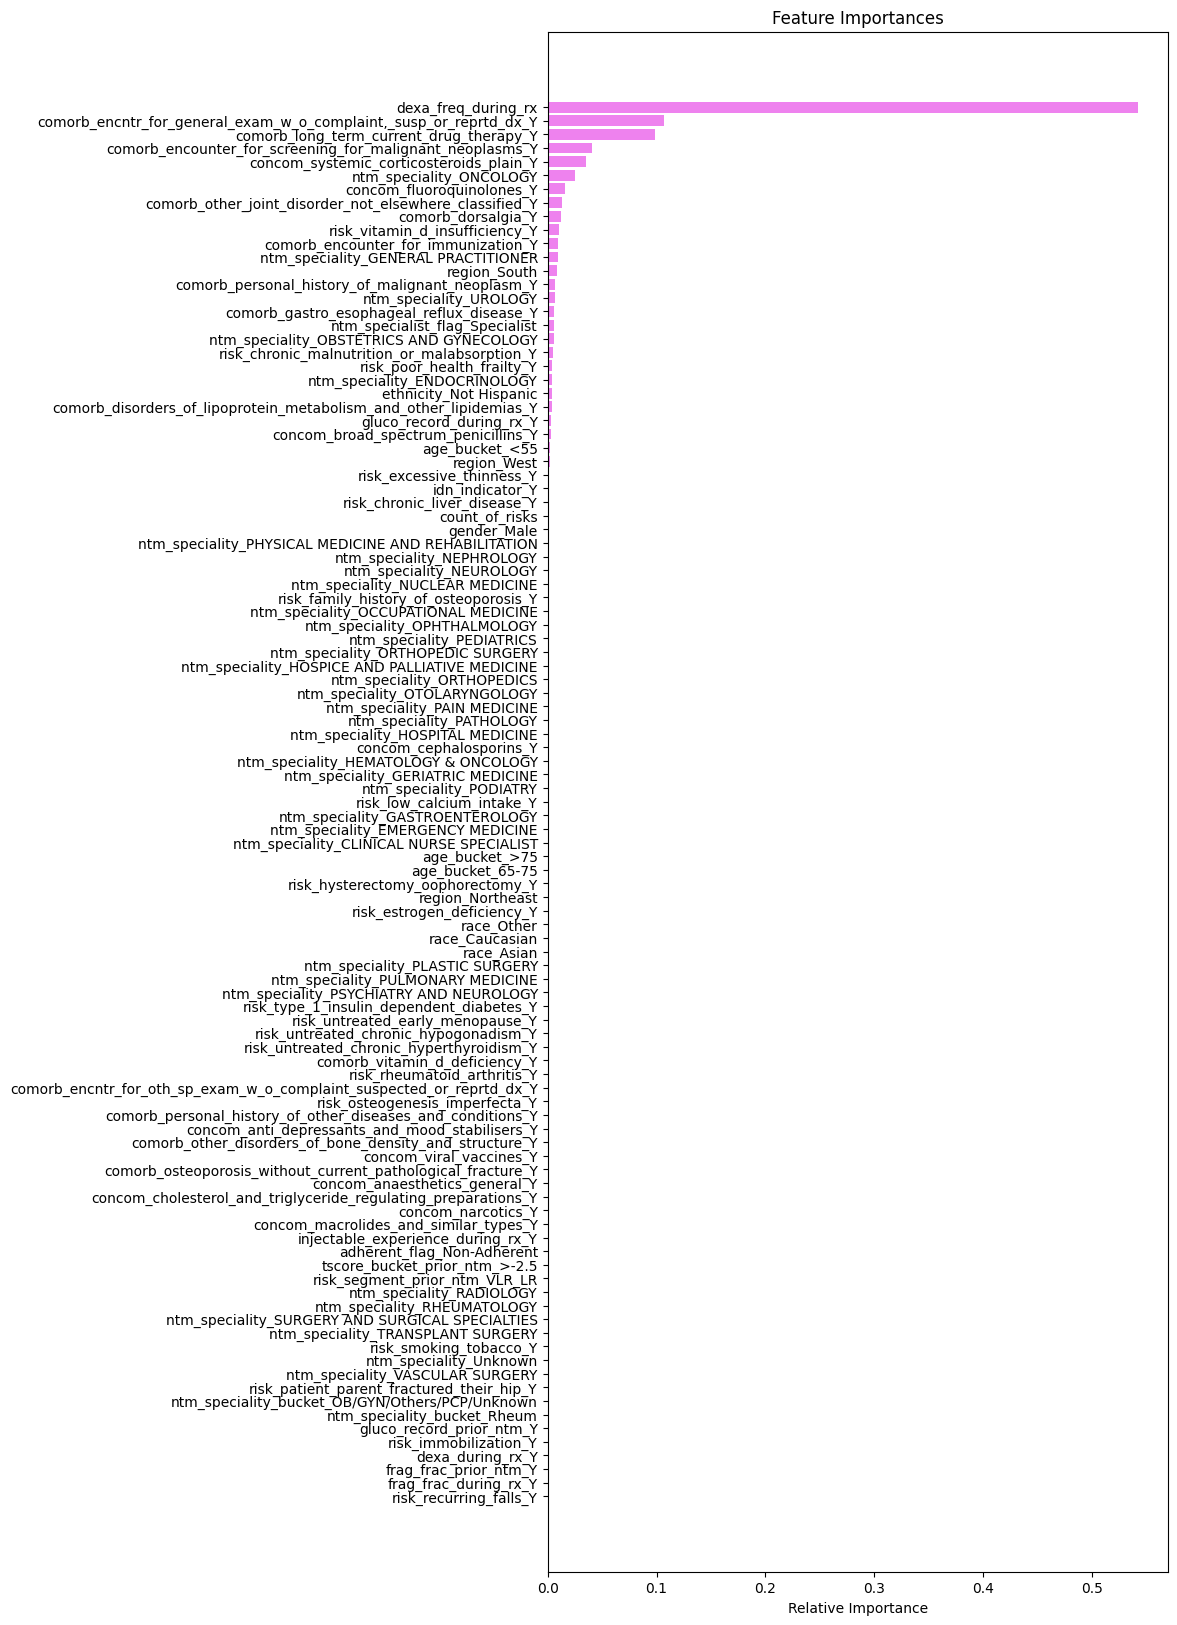

In [22]:
importances = estimator.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8, 20))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

In [23]:
feature_importance_list = list(zip(feature_names, importances))

feature_importance_list = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)

print(feature_importance_list)

[('dexa_freq_during_rx', 0.5422030837046071), ('comorb_encntr_for_general_exam_w_o_complaint,_susp_or_reprtd_dx_Y', 0.10684984542992126), ('comorb_long_term_current_drug_therapy_Y', 0.09868675408056087), ('comorb_encounter_for_screening_for_malignant_neoplasms_Y', 0.041228792087862225), ('concom_systemic_corticosteroids_plain_Y', 0.03538150424715944), ('ntm_speciality_ONCOLOGY', 0.025190095742419646), ('concom_fluoroquinolones_Y', 0.01613368415957519), ('comorb_other_joint_disorder_not_elsewhere_classified_Y', 0.013265440210803578), ('comorb_dorsalgia_Y', 0.012248471855597427), ('risk_vitamin_d_insufficiency_Y', 0.010670387732471857), ('comorb_encounter_for_immunization_Y', 0.009979875387879507), ('ntm_speciality_GENERAL PRACTITIONER', 0.00951126790354171), ('region_South', 0.008892112703242585), ('comorb_personal_history_of_malignant_neoplasm_Y', 0.006887600713037481), ('ntm_speciality_UROLOGY', 0.006387698970641097), ('comorb_gastro_esophageal_reflux_disease_Y', 0.006334377046663233)

#Extracting features with important value greater than zero

In [24]:
important_features = [feature for feature, importance in zip(feature_names, importances) if importance > 0]

print(important_features)

['dexa_freq_during_rx', 'count_of_risks', 'gender_Male', 'ethnicity_Not Hispanic', 'region_South', 'region_West', 'age_bucket_<55', 'ntm_speciality_ENDOCRINOLOGY', 'ntm_speciality_GENERAL PRACTITIONER', 'ntm_speciality_OBSTETRICS AND GYNECOLOGY', 'ntm_speciality_ONCOLOGY', 'ntm_speciality_UROLOGY', 'ntm_specialist_flag_Specialist', 'gluco_record_during_rx_Y', 'idn_indicator_Y', 'comorb_encounter_for_screening_for_malignant_neoplasms_Y', 'comorb_encounter_for_immunization_Y', 'comorb_encntr_for_general_exam_w_o_complaint,_susp_or_reprtd_dx_Y', 'comorb_other_joint_disorder_not_elsewhere_classified_Y', 'comorb_long_term_current_drug_therapy_Y', 'comorb_dorsalgia_Y', 'comorb_disorders_of_lipoprotein_metabolism_and_other_lipidemias_Y', 'comorb_personal_history_of_malignant_neoplasm_Y', 'comorb_gastro_esophageal_reflux_disease_Y', 'concom_systemic_corticosteroids_plain_Y', 'concom_fluoroquinolones_Y', 'concom_broad_spectrum_penicillins_Y', 'risk_chronic_malnutrition_or_malabsorption_Y', 'ris

In [25]:
X_train_imp = X_train[important_features]
X_test_imp = X_test[important_features]

In [26]:
model0_imp = DecisionTreeClassifier(random_state = 1)
model0_imp.fit(X_train_imp, y_train)

DecisionTreeClassifier(random_state=1)

In [27]:
dec_tree_imp_train_default = model_performance_classification_sklearn(model0_imp, X_train_imp, y_train)
dec_tree_imp_train_default

,Accuracy,Recall,Precision,F1
0,0.99374,0.98337,1.0,0.991615


In [28]:
dec_tree_imp_test_default = model_performance_classification_sklearn(model0_imp, X_test_imp, y_test)
dec_tree_imp_test_default

,Accuracy,Recall,Precision,F1
0,0.708171,0.614987,0.611825,0.613402


###Prepruning to reduce overfitting

In [29]:
# Choose the type of classifier.
estimator_imp = DecisionTreeClassifier(random_state=1, class_weight="balanced")

# Grid of parameters to choose from
parameters = {
    "max_depth": np.arange(2, 7, 2),
    "max_leaf_nodes": [50, 75, 150, 250],
    "min_samples_split": [10, 30, 50, 70],
}

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(f1_score)

# Run the grid search
grid_obj = GridSearchCV(estimator_imp, parameters, scoring=acc_scorer, cv=5)
grid_obj = grid_obj.fit(X_train_imp, y_train)

# Set the clf to the best combination of parameters
estimator_imp = grid_obj.best_estimator_

# Fit the best algorithm to the data.
estimator_imp.fit(X_train_imp, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=6, max_leaf_nodes=50,
                       min_samples_split=50, random_state=1)

In [30]:
#evaluating estimator imp
dec_tree_imp_train_pre = model_performance_classification_sklearn(estimator_imp, X_train_imp, y_train)
dec_tree_imp_train_pre

,Accuracy,Recall,Precision,F1
0,0.818447,0.804878,0.737056,0.769475


In [31]:
#test
dec_tree_imp_test_pre = model_performance_classification_sklearn(estimator_imp, X_test_imp, y_test)
dec_tree_imp_test_pre

,Accuracy,Recall,Precision,F1
0,0.761673,0.715762,0.67233,0.693367


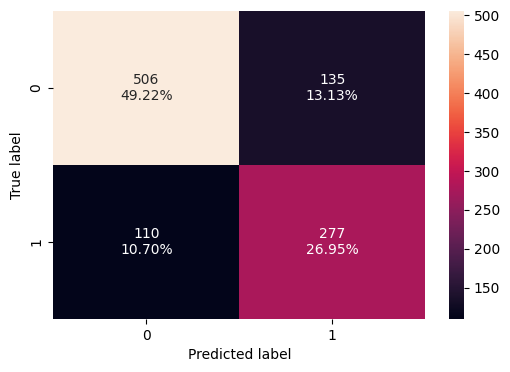

In [32]:
confusion_matrix_sklearn(estimator_imp, X_test_imp, y_test)

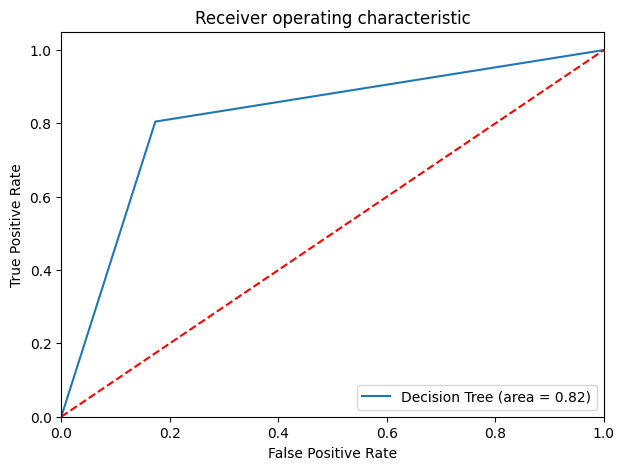

In [33]:
#dec tree with important features
dt_imp_roc_auc_train = roc_auc_score(y_train, estimator_imp.predict(X_train_imp))
fpr, tpr, thresholds = roc_curve(y_train, estimator_imp.predict(X_train_imp))
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Decision Tree (area = %0.2f)" % dt_imp_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

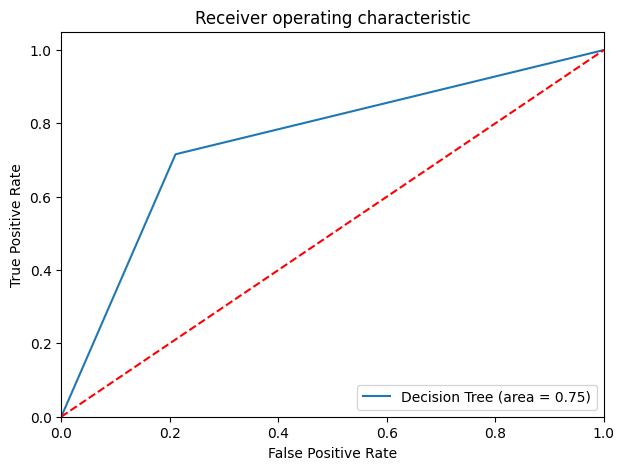

In [34]:
dt_imp_roc_auc_test = roc_auc_score(y_test, estimator_imp.predict(X_test_imp))
fpr, tpr, thresholds = roc_curve(y_test, estimator_imp.predict(X_test_imp))
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Decision Tree (area = %0.2f)" % dt_imp_roc_auc_test)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()